<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S26_sorter_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
%pip install -q -U gtbook


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import gtsam

import plotly.graph_objs as go
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

from gtbook.discrete import Variables
from gtbook.display import pretty, show

# recap from S11:
variables = Variables()
categories = ["cardboard", "paper", "can", "scrap metal", "bottle"]
Category = variables.discrete("Category", categories)


# Learning

>: We can learn prior and sensor models from data we collect.

In [3]:
from gtbook.display import randomImages
from IPython.core.display import display
display(randomImages(2, 6, "steampunk", 1))

At various times in this chapter we seemed to pull information out of thin air. But the various probabilistic models we used can be *learned* from data. This is what we will discuss below:

- In section 1 we talked about priors over state. Here we will estimate prior from counts, and talk about addding "bogus counts" in the case that we do not have a lot of data.
- In section 3 we discussed sensor models. Below we estimate those sensor models from counts recorded for each of the possible states.
- Counting works for discrete sensors, but for continuous sensors we have to a bit more work. We will end this section by showing how to fit simple Gaussian sensor models to data.


## Estimating a Discrete PMF

> : Count the occurences.

In section 1 we introduced the notion of a probability mass function (PMF) to characterize the *a priori* probability of being in a certain state. It turns out that the *normalized counts* we obtain when observing states over a long time period is a good approximation for the PMF. The more samples that go in, the better the approximation.

As an example, let us assume that at a different trash sorting cell we observe the a while and note what category each piece of trash is in. We might see something like:

In [4]:
data = [1, 1, 1, 2, 1, 1, 1, 3, 0, 0, 0, 1,
        2, 2, 2, 2, 4, 4, 4, 1, 1, 2, 1, 2, 1]


Using `numpy` can get the counts using the [`bincount`](https://numpy.org/doc/stable/reference/generated/numpy.bincount.html) function. We then plot the counts using plotly express:

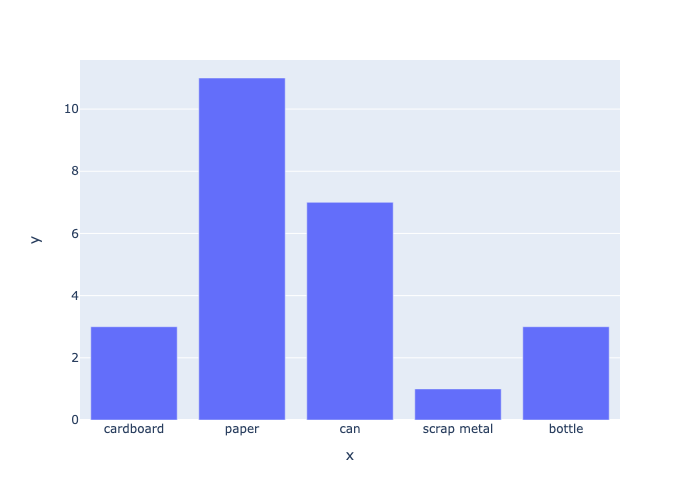

In [5]:
counts = np.bincount(data)
px.bar(x=categories, y=counts)

We can then estimate the probability of each category $c_k$ simply by dividing the count $N_k$ by the number of data points $N$:

$$P(x_k) \approx \frac{C_k}{N}$$

In our example:

In [6]:
estimated_pmf = counts/sum(counts)
print(f"Counts: {counts}\nEstimated PMF: {estimated_pmf}")

Counts: [ 3 11  7  1  3]
Estimated PMF: [0.12 0.44 0.28 0.04 0.12]


We can now easily turn it into a GTSAM discrete prior for pretty-printing:


In [7]:
# prior = gtsam.DiscretePrior(Category, estimated_pmf) # will be in gtsam 4.2a3
prior = gtsam.DiscretePrior(Category, "0.12/0.44/0.28/0.04/0.12")
pretty(prior, variables)

Category,value
cardboard,0.12
paper,0.44
can,0.28
scrap metal,0.04
bottle,0.12


Note that the counts are the only quantitities one needs to estimate a PMF: a statistication would say that the counts are a **sufficient statistic** for the purpose of estimating the probability distribution. In fact, GTSAM can just take the counts themselves, as it normalizes internally:


In [8]:
prior = gtsam.DiscretePrior(Category, "3/11/7/1/3")
pretty(prior, variables)

Category,value
cardboard,0.12
paper,0.44
can,0.28
scrap metal,0.04
bottle,0.12


### Smoothing

> : We make up fake data to deal with sparse data.


A trick that statisticians and machine learning practicioners employ is "smoothing", which is especially important when you have very little data. Indeed, sometimes a category value will get zero counts, even though you *know* that occasionally we wil get that category. **Smoothing* is the process of letting the estimator know this by adding "pseudo-counts". For example, a very common approach is to simply add 1 to every count:


In [9]:
counts, _ = np.histogram(data, bins=5)
smoothed_counts = counts + 1
smoothed_pmf = smoothed_counts/sum(smoothed_counts)


Comparing the two, we see that the smoothed PMF is more uniform, and accords more probability "undercounted" categories than the raw counts:


In [10]:
# Some pandas magic to display a nice side-by-side table:
df = pd.DataFrame(
    {"raw": estimated_pmf, "smoothed": smoothed_pmf}, index=categories)
df


,raw,smoothed
cardboard,0.12,0.133333
paper,0.44,0.400000
can,0.28,0.266667
scrap metal,0.04,0.066667
bottle,0.12,0.133333


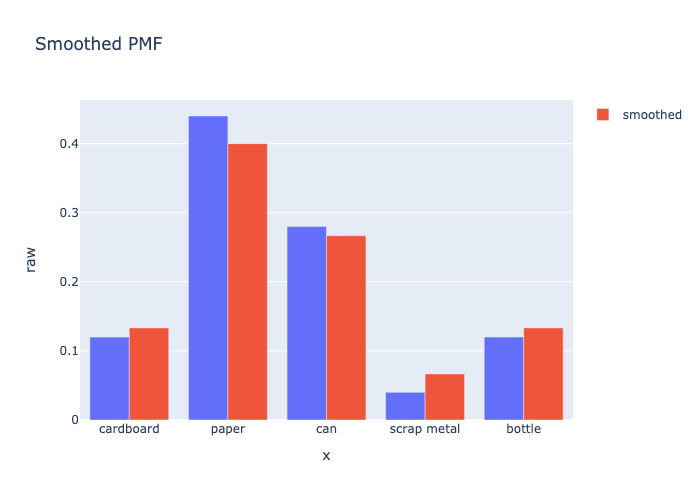

In [11]:
# and some plotly magic to plot them side by side:
fig = px.bar(df, x=categories, y="raw", barmode="group", title="Smoothed PMF")
fig.add_bar(x=categories, y=smoothed_pmf, name="smoothed")


## Modeling a Sensor from Data

> : When learning a conditional distribution, we need to separate out the counts based on the conditioning variable.


A `gtsam.DiscreteConditional` takes the counts, grouped by the conditioning variable. In our case, `Category` can take on 5 separate values, and hence we have five groups. For example a binary sensor:


In [12]:
Conductivity = variables.binary("Conductivity")
P_Conductivty_Category = gtsam.DiscreteConditional(
    Conductivity, [Category], "80/20 40/60 12/4 100/150 10/10")
pretty(P_Conductivty_Category, variables)


Category,false,true
cardboard,0.8,0.2
paper,0.4,0.6
can,0.75,0.25
scrap metal,0.4,0.6
bottle,0.5,0.5


And for a three-valued sensor:


In [13]:
ThreeValued = variables.discrete("ThreeValued", ["Value1", "Value2", "Value3"])
P_ThreeValued_Category = gtsam.DiscreteConditional(ThreeValued, [Category],
                                                   "10/70/20 20/20/60 2/10/4 100/100/50 5/5/10")
pretty(P_ThreeValued_Category, variables)


Category,Value1,Value2,Value3
cardboard,0.1,0.7,0.2
paper,0.2,0.2,0.6
can,0.125,0.625,0.25
scrap metal,0.4,0.4,0.2
bottle,0.25,0.25,0.5


Once again, note that the *rows* are normalized to be proper PMFs, given the conditioning variable. The columns are not, and instead form likelihoods over the category, when a particular value is observed for `ThreeValued` .

Again, we can add pseudo-counts to all counts if we have very little data, or to specific groups if you only have prior knowledge about a particular setting. If you really know nothing about the behavior of a sensor, adding a pseudo-count of 1 is a good thing to do in general: it prevents according zero probability to a rare event. The downside is that you will have a biased view of the CPT, but this disadvantage quickly goes away as you add more and more data.


## Fitting a Gaussian

If we observe *continuous* data that we suspect is generated from a Gaussian density, then we can easily fit the estimated mean $\hat{\mu}$ by 

$$\hat{\mu} = \frac{1}{N} \sum_i x_i.$$ 

The other statistic we need is the variance $\sigma^2$ defined as the expectation of the squared error:

$$E[(x-\mu)^2].$$

Fitting the variance can be done after we obtained the empirical mean $\hat{\mu}$, by

$$\widehat{\sigma^2} = \frac{1}{N-1} \sum_i (x_i-\hat{\mu})^2.$$ 

The standard deviation is defined as the square root of the variance, and hence: 

$$\widehat{\sigma} = \sqrt{\widehat{\sigma^2}}.$$

**Note**: above we divide by $N-1$ and not by $N$: informally, the reason is that we already "used up" one data point by estimating the mean from our samples, and we correct for that to get an "unbiased" estimate for the variance.


Below is some python code to do just that, using the `numpy` library. Let us first generate some "data" from a Gaussian with known mean and standard deviation:


In [14]:
mean = 200  # grams, say...
stddev = 50  # also in grams
N = 200  # number of samples
data = np.random.normal(mean, stddev, N)


When we plot a histogram, we can see the typical "bell curve" shape emerge (try increasing N!):


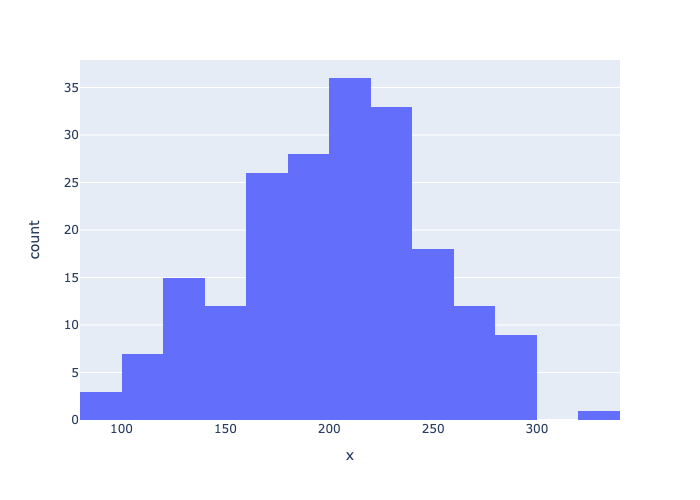

In [15]:
nbins = N//10
px.histogram(x=data, nbins=nbins)


The sample mean is easy enough with `np.mean` :


In [16]:
mu_hat = np.mean(data)
mu_hat


201.15151149975318

In [17]:
np.var(data, ddof=1)


2229.428807685623

Of course we can do this by ourselves as well:


Note that though with 200 samples the histogram is quite "messy", the sample mean $\hat{\mu}$ is close to the true mean $\mu=200$.

There is also a function `np.var` that calculates the sample variance, but we need to take care to provide the `ddof=1` argument to get the unbiased estimate (do `help(np.var)` to find out more).


Here is the code for variance:


In [18]:
var_hat = np.sum(np.square(data-mu_hat))/(N-1)
var_hat


2229.428807685623

By taking the square root, we see that it matches our ground truth standard deviation $\sigma$ quite well:


In [19]:
sigma_hat = np.sqrt(var_hat)
print(sigma_hat)


47.21682759023125


### Comparison

We can now plot our estimated Gaussian together with the data:


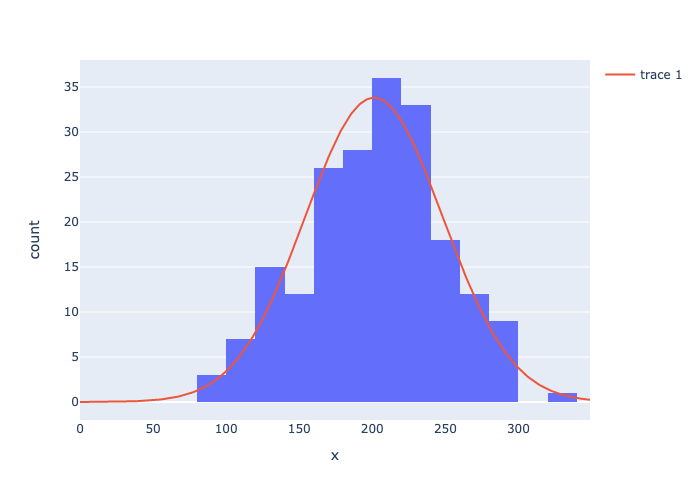

In [20]:
fig = px.histogram(x=data, nbins=nbins)
X = np.arange(0, 350)
K = N*(400/nbins)/np.sqrt(2*np.pi*var_hat)  # expected height of histogram...
fig.add_trace(go.Scatter(x=X, y=K * np.exp(-0.5*np.square(X-mu_hat)/var_hat)))
fig


## Summary

We saw above that learning conditional probability tables accounts amounts to counting the occurrence of certain events. In the case of sensor models, it is really about the co-occurrence of an event: how often do we see a particular sensor reading in a particular state? Finally if the sensor is continuous, we have to posit a parametric model, in this case we use the Gaussian, and use techniques from statistics to estimate its parameters. For a Gaussian, we need to only estimate its mean $\mu$ and its a variance $\sigma^2$, and weused techniques from statistics to estimate these.

In the case of discrete sensors we also looked at a very simple form of smoothing to cope with the absence of certain counts, which is common for rare events. In fact, this amounts to introducing a *hyperprior* on the parameters to be estimated - in this case the numbers of a conditional probability table. Hyperpriors are also available for estimating parameters of a Gaussian, but that is beyond the scope of this section.

You might think it is a bit of a stretch to call these procedures "learning". And indeed, they are simple parameter estimation problems as encountered in a statistics 101 class. However, although we will look at much more sophisticated learning approaches, even these simple algorithms *learn* about the world from data. Based on the sensor models, a robot will change how it acts in the world. Together with a value system, supplied in the form of a cost matrix by its user, the robot will make more optimal decisions by observing how the environments behaves.